In [386]:
# N = 6000; C = 2 # fear
# N = 6000; C = 3 # happy
# N = 5000; C = 0 # neutral
N = 6000; C = 1 # sad

# neutral, sad, fear, happy

In [387]:
# Rename the channels
# rename_dict = {'Fp1': 'FP1', 'Fp2': 'FP2', 'FPz' : 'FPZ',
#            'Fz' : 'FZ', 'FCz' : 'FCZ', 'Cz' : 'CZ', 
#            'CPz' : 'CPZ', 'Pz' : 'PZ', 'Oz' : 'OZ', 
#            'PO9' : 'CB1','PO10' : 'CB2',}

SEED_IV_CHLS = [
    'Fp1', 'Fpz', 'Fp2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4',
    'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8',
    'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3',
    'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz',
    'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8',
    'PO9', 'O1', 'Oz', 'O2', 'PO10']
SEED_IV_SUBNUM = 15
SEED_IV_LOCATION = [
    ['-', '-', '-', 'Fp1', 'Fpz', 'Fp2', '-', '-', '-'],
    ['-', '-', '-', 'AF3', '-', 'AF4', '-', '-', '-'],
    ['F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8'],
    ['FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8'],
    ['T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8'],
    ['TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8'],
    ['P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8'],
    ['-', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', '-'],
    ['-', '-', 'PO9', 'O1', 'Oz', 'O2', 'PO10', '-', '-']]

def load_dataset_info(dataset):
    if dataset == 'GAMEEMO': return GAMEEMO_SUBNUM, GAMEEMO_CHLS, GAMEEMO_LOCATION
    elif dataset == 'SEED': return SEED_SUBNUM, SEED_CHLS, SEED_LOCATION
    elif dataset == 'SEED_IV': return SEED_IV_SUBNUM, SEED_IV_CHLS, SEED_IV_LOCATION
    elif dataset == 'DEAP': return DEAP_SUBNUM, DEAP_CHLS, DEAP_LOCATION

def get_sfreq(dataset):
    if dataset == 'GAMEEMO':
        sfeq = 128; l_freq, h_freq = 0.16, 43
    elif dataset == 'SEED':
        sfeq = 200; #l_freq, h_freq = 0, 75; 
        l_freq, h_freq = 2, 50
    elif dataset == 'SEED_IV':
        sfeq = 200; #l_freq, h_freq = 1, 75;
        l_freq, h_freq = 2, 50
    elif dataset == 'DEAP':
        sfeq = 128; l_freq, h_freq = 4, 45
    return sfeq, l_freq, h_freq

In [388]:
%matplotlib inline

import os
from os.path import join, exists
from pathlib import Path
import numpy as np
import mne
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from PIL import Image

DATASET_NAME = 'SEED_IV' #'GAMEEMO, SEED, SEED_IV, DEAP'
LABEL = '4'           # 'v', 'a' GAMEEMO/DEAP, '4' SEED, SEED_IV
MODEL_NAME = 'CCNN'   # CCNN, TSC, EEGNet, DGCNN
FEATURE = 'DE'     # 'DE, PSD, raw'

PROJECT = 'High'
THRESHOLDS = ['95']

if MODEL_NAME == 'CCNN': SHAPE = 'grid'
elif MODEL_NAME == 'TSC' or MODEL_NAME == 'EEGNet': SHAPE = 'expand'; FEATURE = 'raw'
elif MODEL_NAME == 'DGCNN': SHAPE = None
# if FEATURE == 'DE': SCALE = None
# elif FEATURE == 'PSD': SCALE = 'log'
# elif FEATURE == 'raw': SCALE = 'standard'
if LABEL == 'a':    train_name = 'arousal'
elif LABEL == 'v':  train_name = 'valence'
else:               train_name = 'emotion'
if MODEL_NAME == 'EEGNet' or MODEL_NAME == 'TSC': MODEL_FEATURE = MODEL_NAME
else: MODEL_FEATURE = '_'.join([MODEL_NAME, FEATURE])

SUB_NUM, CHLS, LOCATION = load_dataset_info(DATASET_NAME)

analysis_file = 'analysis'
analysis_path = Path(join(os.getcwd(), 'results', DATASET_NAME, MODEL_FEATURE, PROJECT, train_name, analysis_file))

if not exists(analysis_path): raise FileNotFoundError(f"File not found: {analysis_path}")
else: print(analysis_path)

/home/hyodol/HYODOL/OOD/results/SEED_IV/CCNN_DE/High/emotion/analysis


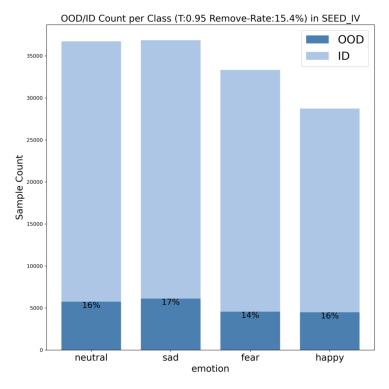

In [389]:
img = Image.open(join(analysis_path,f'ID_OOD_class{THRESHOLDS[0]}.png'))
plt.imshow(img); plt.axis('off'); plt.show()

In [79]:
# Load ID/OOD from .npz file
IND_npz = f'IND_{THRESHOLDS[0]}.npz'
OOD_npz = f'OOD_{THRESHOLDS[0]}.npz'

def load_data(dir, npz):
    data = np.load(join(dir, npz), allow_pickle=True)
    X, Y = data['X'], data['Y']
    labels, subids = Y[:, 0], Y[:, 1]
    print(X.shape, labels.shape, subids.shape)
    return X, labels, subids

# Load ID,OOD
X_ind, labels_ind, subids_ind = load_data(analysis_path, IND_npz)
X_ood, labels_ood, subids_ood = load_data(analysis_path, OOD_npz)

(114742, 4, 9, 9) (114742,) (114742,)
(20933, 4, 9, 9) (20933,) (20933,)


In [80]:
def reverse_grid(datas, channel, location):
    CHANNEL_LOCATION_DICT = format_channel_location_dict(channel, location)
    togrid = ToGrid(CHANNEL_LOCATION_DICT)
    return np.array([togrid.reverse(sample) for sample in datas])

def format_channel_location_dict(channel_list, location_list):
    location_list = np.array(location_list)
    output = {}
    for channel in channel_list:
        if len(np.argwhere(location_list == channel)):
            location = (np.argwhere(location_list == channel)[0]).tolist()
            output[channel] = location
    return output
    
class ToGrid:
    def __init__(self, channel_location_dict):
        self.channel_location_dict = channel_location_dict

        loc_x_list = []
        loc_y_list = []
        for _, (loc_y, loc_x) in channel_location_dict.items():
            loc_x_list.append(loc_x)
            loc_y_list.append(loc_y)
        self.width = max(loc_x_list) + 1
        self.height = max(loc_y_list) + 1

    def apply(self, eeg):
        # num_electrodes x timestep
        outputs = np.zeros([self.height, self.width, eeg.shape[-1]])
        # 9 x 9 x timestep
        for i, (loc_y, loc_x) in enumerate(self.channel_location_dict.values()):
            outputs[loc_y][loc_x] = eeg[i]

        outputs = outputs.transpose(2, 0, 1)
        # timestep x 9 x 9
        return outputs
        
    def reverse(self, eeg):
        # timestep x 9 x 9
        eeg = eeg.transpose(1, 2, 0)
        # 9 x 9 x timestep
        num_electrodes = len(self.channel_location_dict)
        outputs = np.zeros([num_electrodes, eeg.shape[2]])
        for i, (x, y) in enumerate(self.channel_location_dict.values()):
            outputs[i] = eeg[x][y]
        # num_electrodes x timestep
        return outputs
        
X_ind = reverse_grid(X_ind, CHLS, LOCATION)
X_ood = reverse_grid(X_ood, CHLS, LOCATION)

print(X_ind.shape, X_ood.shape)

(114742, 62, 4) (20933, 62, 4)


In [81]:
print(train_name)
label_class = np.unique(labels_ind)
label_class

emotion


array([0, 1, 2, 3])

# Filter label C:neutral, sad, fear, happy

In [82]:
label_names = ['neutral', 'sad', 'fear', 'happy']
label_name = label_names[C]

X_ind_C = X_ind[labels_ind == C]
subids_ind_C = subids_ind[labels_ind == C]

X_ood_C = X_ood[labels_ood == C]
subids_ood_C = subids_ood[labels_ood == C]

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


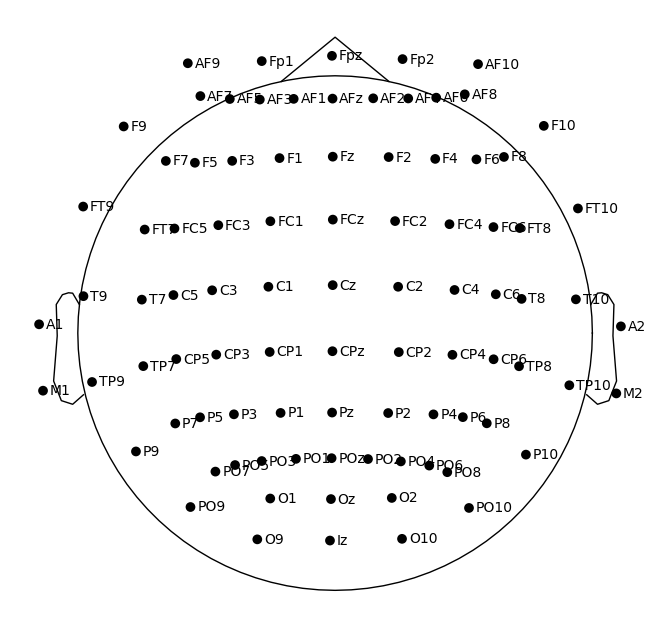

In [83]:
# Create Info
sfreq, l_freq, h_freq = get_sfreq(DATASET_NAME)
info = mne.create_info(ch_names=CHLS, sfreq=sfreq, ch_types="eeg")

# Assign the montage
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage, match_case=True, match_alias=True, on_missing='ignore', verbose=None)
montage.plot(show_names=True);

In [84]:
# Create events based on subids 
events_ind = np.column_stack([np.arange(len(subids_ind_C)), np.zeros(len(subids_ind_C), dtype=int), subids_ind_C])
events_ind

array([[    0,     0,     1],
       [    1,     0,     1],
       [    2,     0,     1],
       ...,
       [30749,     0,    15],
       [30750,     0,    15],
       [30751,     0,    15]])

In [85]:
event_id_ind = {f'sub_{int(i)}': int(i) for i in np.unique(subids_ind_C)}
event_id_ind

{'sub_1': 1,
 'sub_2': 2,
 'sub_3': 3,
 'sub_4': 4,
 'sub_5': 5,
 'sub_6': 6,
 'sub_7': 7,
 'sub_8': 8,
 'sub_9': 9,
 'sub_10': 10,
 'sub_11': 11,
 'sub_12': 12,
 'sub_13': 13,
 'sub_14': 14,
 'sub_15': 15}

In [86]:
events_ood = np.column_stack([np.arange(len(subids_ood_C)), np.zeros(len(subids_ood_C), dtype=int), subids_ood_C])
event_id_ood = {f'sub_{int(i)}': int(i) for i in np.unique(subids_ood_C)}

In [87]:
# Create EpochsArray
epochs_ind = mne.EpochsArray(X_ind_C, info, events=events_ind, event_id=event_id_ind)
epochs_ood = mne.EpochsArray(X_ood_C, info, events=events_ood, event_id=event_id_ood)
print(epochs_ind)
print(epochs_ood)

Not setting metadata
30752 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
6118 matching events found
No baseline correction applied
0 projection items activated
<EpochsArray |  30752 events (all good), 0 – 0.015 s, baseline off, ~58.3 MB, data loaded,
 'sub_1': 1394
 'sub_2': 2155
 'sub_3': 2324
 'sub_4': 2344
 'sub_5': 2061
 'sub_6': 2339
 'sub_7': 2311
 'sub_8': 1962
 'sub_9': 2242
 'sub_10': 1380
 and 5 more events ...>
<EpochsArray |  6118 events (all good), 0 – 0.015 s, baseline off, ~11.7 MB, data loaded,
 'sub_1': 1064
 'sub_2': 303
 'sub_3': 134
 'sub_4': 114
 'sub_5': 397
 'sub_6': 119
 'sub_7': 147
 'sub_8': 496
 'sub_9': 216
 'sub_10': 1078
 and 5 more events ...>


# Sampling

In [88]:
def random_sample_epochs(epochs, num_samples):
    random_indices = np.random.choice(len(epochs), num_samples, replace=False)
    return epochs[random_indices]

random_epochs_ind = random_sample_epochs(epochs_ind, N)
random_epochs_ood = random_sample_epochs(epochs_ood, N)

print(random_epochs_ind)
print(random_epochs_ood)

print(random_epochs_ind.get_data().shape, random_epochs_ood.get_data().shape)

<EpochsArray |  6000 events (all good), 0 – 0.015 s, baseline off, ~11.4 MB, data loaded,
 'sub_1': 289
 'sub_2': 429
 'sub_3': 441
 'sub_4': 478
 'sub_5': 399
 'sub_6': 470
 'sub_7': 452
 'sub_8': 374
 'sub_9': 428
 'sub_10': 256
 and 5 more events ...>
<EpochsArray |  6000 events (all good), 0 – 0.015 s, baseline off, ~11.4 MB, data loaded,
 'sub_1': 1045
 'sub_2': 298
 'sub_3': 131
 'sub_4': 111
 'sub_5': 391
 'sub_6': 117
 'sub_7': 144
 'sub_8': 484
 'sub_9': 212
 'sub_10': 1056
 and 5 more events ...>
(6000, 62, 4) (6000, 62, 4)


# DE ~ 정규분포..
## 차이가 안보임

In [112]:
freq_bands = ['Theta', 'Alpha', 'Beta', 'Gamma']

def get_minmax(inds, oods):
    combined = np.concatenate([inds, oods], axis=0)
    return np.min(combined), np.max(combined)

def get_indood(epochs_ind, epochs_ood):    
    ind_band = {band: [] for band in freq_bands}
    ood_band = {band: [] for band in freq_bands}
    
    for i, band in enumerate(freq_bands):
        print(band)

        de_ind = epochs_ind.get_data()[:,:, i] #samples, channels, freq
        de_ood = epochs_ood.get_data()[:,:, i]
        
        # Average per epoch
        inds = np.mean(de_ind, axis=0)
        oods = np.mean(de_ood, axis=0)
                                                             
        # Normalize
        min_val, max_val = get_minmax(inds, oods)
        print(min_val, max_val)
        
        inds = (inds - min_val) / (max_val - min_val)
        oods = (oods - min_val) / (max_val - min_val)
               
        ind_band[band] = inds
        ood_band[band] = oods
        
    return ind_band, ood_band

band_ind, band_ood = get_indood(random_epochs_ind, random_epochs_ood)

Theta
0.9858189089758136 3.20536452666085
Alpha
0.9807333740839644 2.9760897632934915
Beta
1.2769857140807792 3.1754336846569156
Gamma
1.1969918005802067 2.9676086894904694


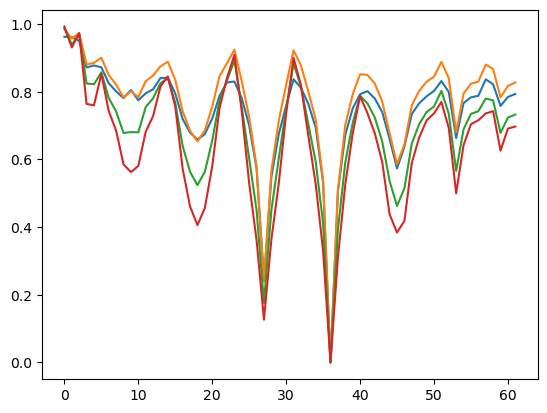

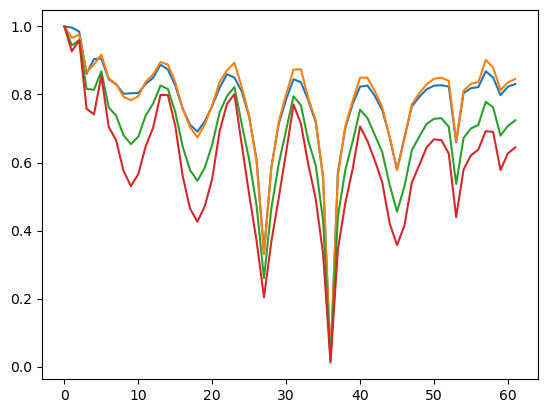

In [113]:

plt.plot(band_ind['Theta'])
plt.plot(band_ind['Alpha'])
plt.plot(band_ind['Beta'])
plt.plot(band_ind['Gamma'])
plt.show()

plt.plot(band_ood['Theta'])
plt.plot(band_ood['Alpha'])
plt.plot(band_ood['Beta'])
plt.plot(band_ood['Gamma'])
plt.show()


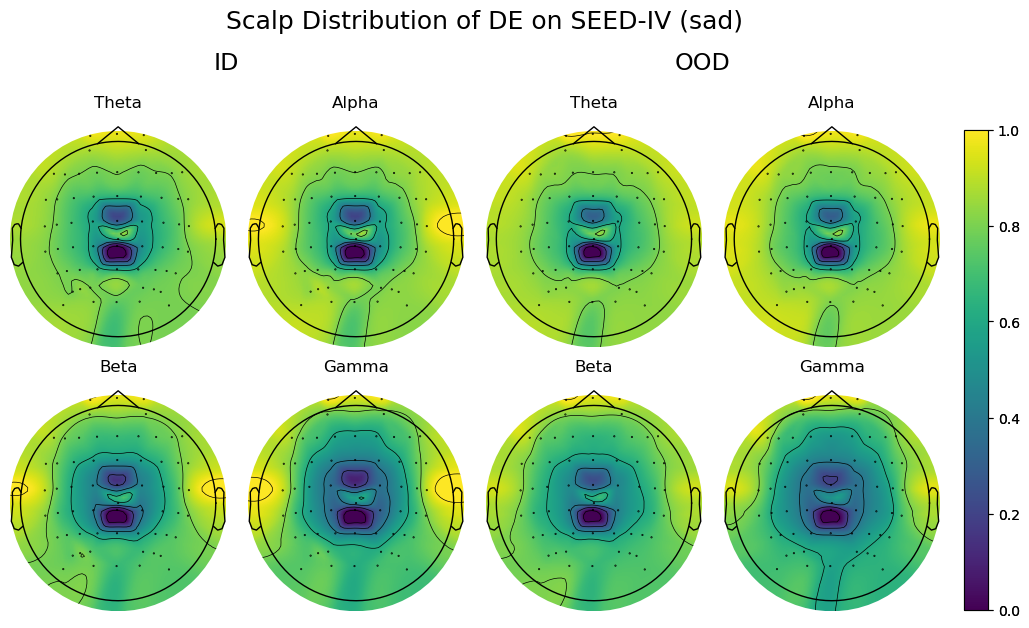

In [348]:
def plot_de_topomap(band_de, label, fig, axs):
    pos = [(0, 0), (0, 1), (1, 0), (1, 1)]
    
    for p, (band, de) in zip(pos, band_de.items()):
        im, _ = mne.viz.plot_topomap(de, epochs_ind.info, axes=axs[p[0], p[1]], cmap='viridis', show=False, vlim=(0,1)) 
        axs[p[0], p[1]].set_title(f"{band}")

    cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.8])
    plt.colorbar(im, cax=cbar_ax, format="%.1f")
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

fig, axs = plt.subplots(2, 4, figsize=(12, 6))

plot_de_topomap(band_ind, 'ID', fig, axs[:, :2])
axs[0, 0].text(1.0, 1.2, 'ID', fontsize=17, ha='center', transform=axs[0, 0].transAxes)

plot_de_topomap(band_ood, 'OOD', fig, axs[:, 2:])
axs[0, 2].text(1.0, 1.2, 'OOD', fontsize=17, ha='center', transform=axs[0, 2].transAxes)

plt.suptitle(f'Scalp Distribution of DE on SEED-IV ({label_name})', ha='center', fontsize=18, x=0.52, y=1.12)
plt.savefig(join(analysis_path, f'{label_name}_analysis.png'), bbox_inches='tight', dpi=300)
plt.show()

## 분포의 차이를 보기

In [216]:
# 통계값
n_channels = 62
n_freq_bands = 4

for i, band in enumerate(freq_bands):
    print(f'{band}\t\tID\t\tOOD')
    std_avg_ch_ind, std_avg_ch_ood = 0, 0
    x_avg_ch_ind, x_avg_ch_ood = 0, 0
    for ch in range(n_channels):
        
        ind_ch_f = random_epochs_ind.get_data()[:, ch, i]
        ood_ch_f = random_epochs_ood.get_data()[:, ch, i]
    
        std_ind, std_ood = np.std(ind_ch_f), np.std(ood_ch_f)
        avg_ind, avg_ood = np.mean(ind_ch_f), np.mean(ood_ch_f)
        
        std_avg_ch_ind += std_ind
        std_avg_ch_ood += std_ood
        
        x_avg_ch_ind += avg_ind
        x_avg_ch_ood += avg_ood

    std_avg_ch_ind /= n_channels
    std_avg_ch_ood /= n_channels
    x_avg_ch_ind /= n_channels
    x_avg_ch_ood /= n_channels
    
    if std_avg_ch_ind < std_avg_ch_ood: opt = '<'
    else: opt='>='
    print(f'\tstd \t{std_avg_ch_ind:.2f}\t{opt}\t{std_avg_ch_ood:.2f}')
    print(f'\tmean\t{x_avg_ch_ind:.2f}\t\t{x_avg_ch_ood:.2f}')

Theta		ID		OOD
	std 	0.37	<	0.44
	mean	2.63		2.70
Alpha		ID		OOD
	std 	0.38	<	0.45
	mean	2.52		2.53
Beta		ID		OOD
	std 	0.42	<	0.52
	mean	2.58		2.55
Gamma		ID		OOD
	std 	0.50	<	0.61
	mean	2.33		2.26


모두 주파수대역에서 OOD의 채널 평균 표준 편차가 높다.

ID가 더 밀집되어 있다 (더 일관된 패턴을 보이고 있을 가능성이 높다.

OOD는 더 넓게 퍼져 있어 불안정하거나 다양한 패턴을 가질 수 있다.

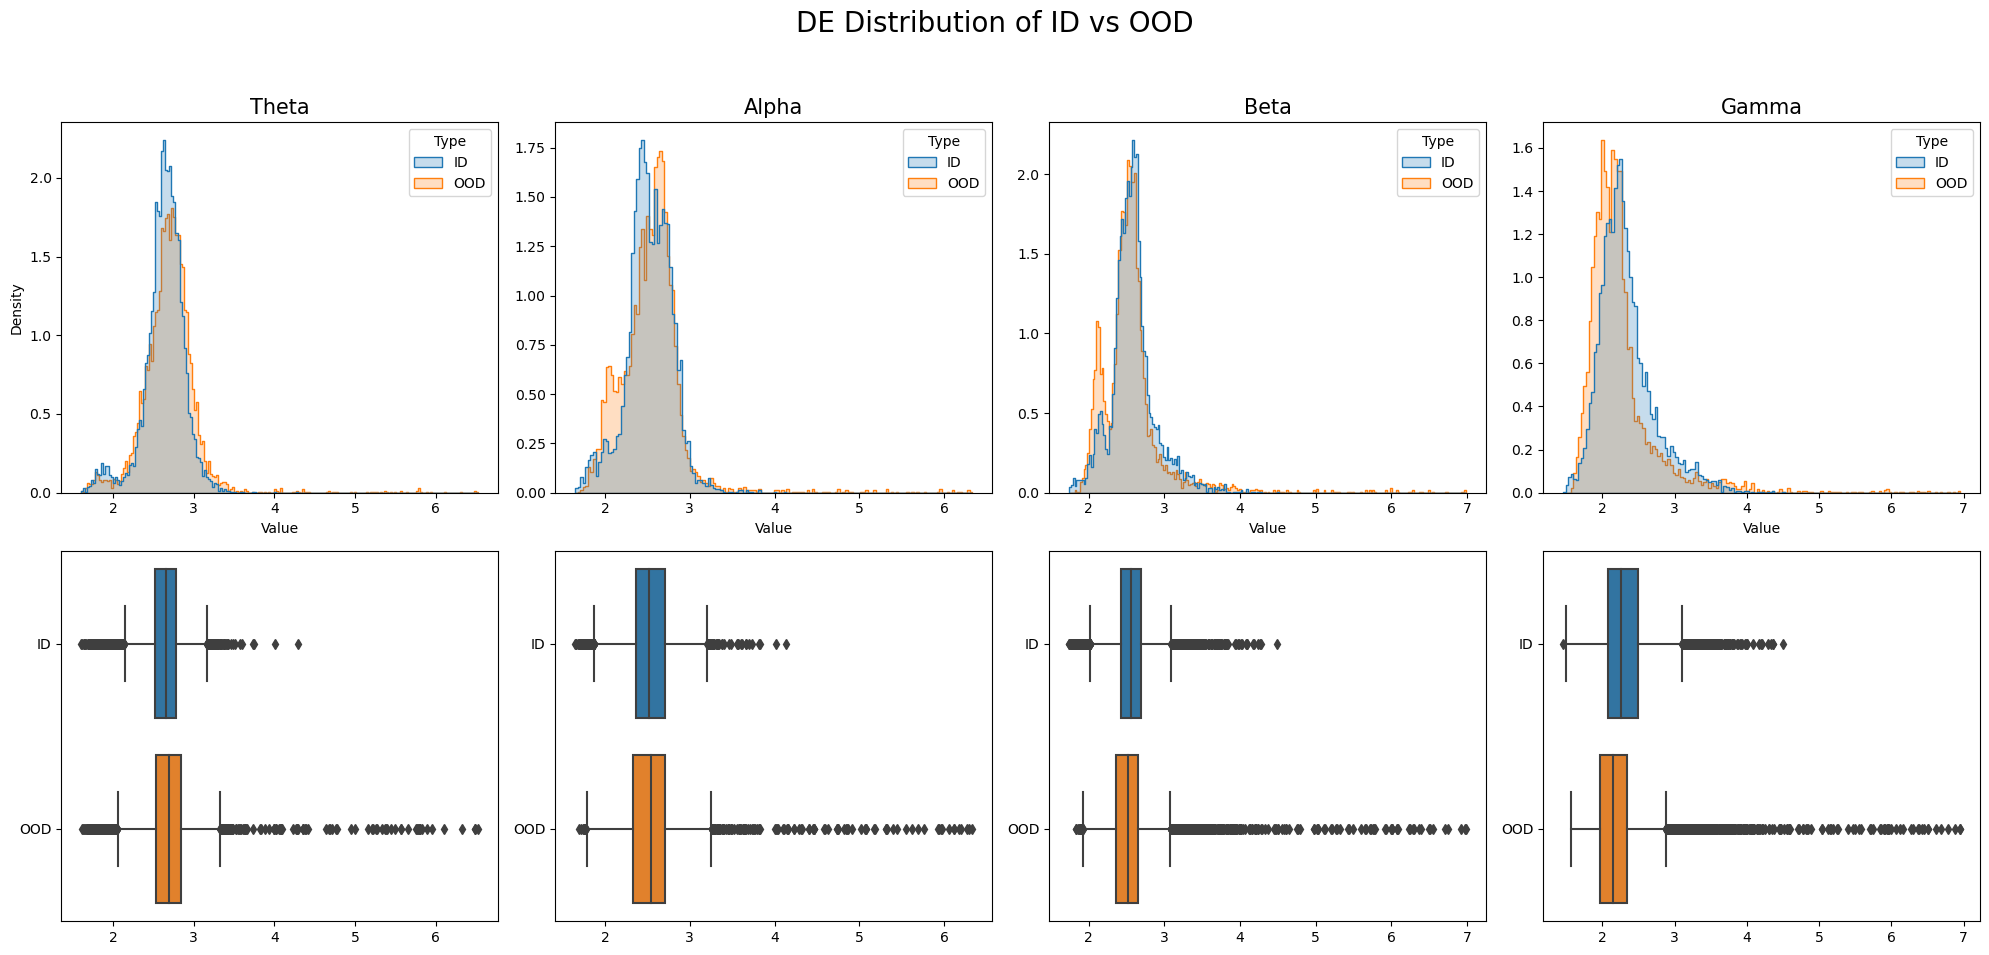

In [394]:
import pandas as pd
import seaborn as sns

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('DE Distribution of ID vs OOD', fontsize=20)

for freq in range(4):
    ind_mean = np.mean(random_epochs_ind.get_data()[:, :, freq], axis=1)
    ood_mean = np.mean(random_epochs_ood.get_data()[:, :, freq], axis=1)
    
    df = pd.DataFrame({
        'Value': np.concatenate([ind_mean, ood_mean]),
        'Type': ['ID'] * len(ind_mean) + ['OOD'] * len(ood_mean)})
    
    sns.histplot(data=df, x='Value', hue='Type', element='step', stat='density', common_norm=False, ax=axs[0, freq])
    # axs[0, freq].set_xlabel('')  # x축 레이블 삭제
    if freq != 0: axs[0, freq].set_ylabel('')  # y축 레이블 삭제
    
    sns.boxplot(data=df, y='Type', x='Value', orient='h', ax=axs[1, freq])
    axs[1, freq].set_xlabel('')  # x축 레이블 삭제
    axs[1, freq].set_ylabel('')  # y축 레이블 삭제
    
    axs[0, freq].set_title(f"{freq_bands[freq]}", fontsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(join(analysis_path, 'hist.png'), dpi=300)
plt.show()

In [ ]:
# from scipy import stats

# am0mean = am0.mean() 
# am1mean = am1.mean()

# #shapiro test p>0.05이면 정규성이 보장된다. 

# sha_a0, a0_pvalue = stats.shapiro(am0)
# sha_a1, a1_pvalue = stats.shapiro(am1)

# #정규성 검정 
# print("정규성검정 결과(Checking the Normality of Data) \n")
# print(f'1. am == 0의 통계량: {sha_a0:.3f} \n am == 0의 p-value = {a0_pvalue:.3f}이다. \n')
# print(f'2. am == 1의 통계량: {sha_a1:.3f} \n am == 1의 p-value = {a1_pvalue:.3f}이다. ')

## Welch's t-test

분산의 유의미한 차이 분석

In [269]:
from scipy.stats import ttest_ind
from scipy import stats

t_values = np.zeros((62, 4))
p_values = np.zeros((62, 4))

for ch in range(n_channels):
    for i, band in enumerate(freq_bands):
        ind_data = random_epochs_ind.get_data()[:, ch, i]
        ood_data = random_epochs_ood.get_data()[:, ch, i]
        
        # Welch's t-test 수행
        t_value, p_value = ttest_ind(ind_data, ood_data, equal_var=False)
        t_values[ch, i] = t_value
        p_values[ch, i] = p_value

print(t_values.shape)

(62, 4)


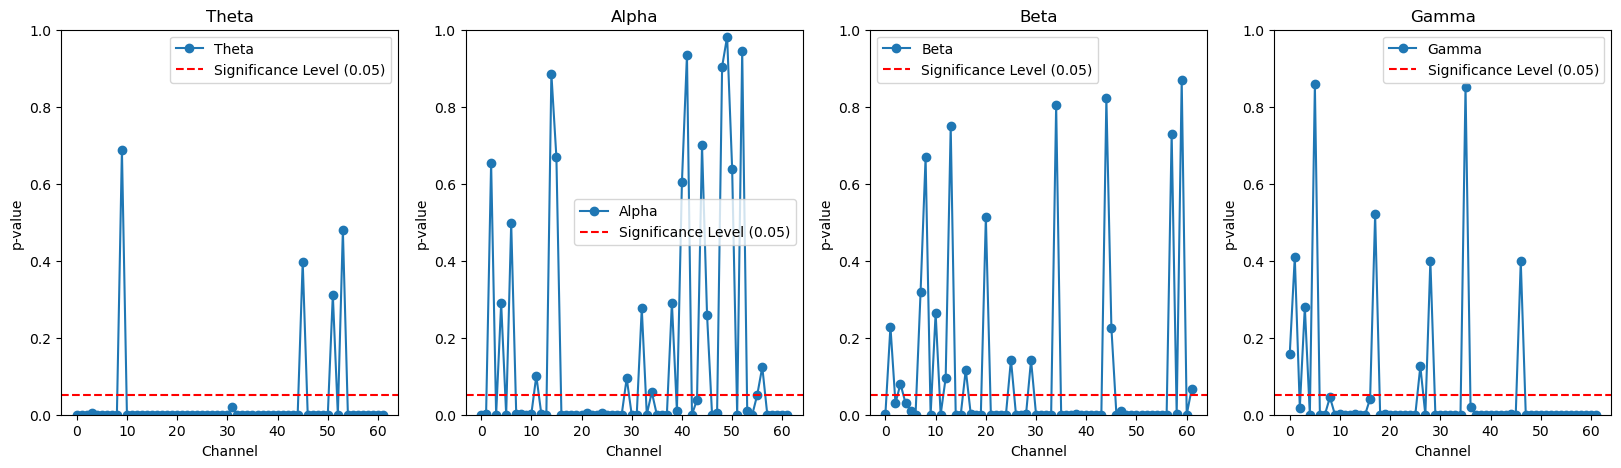

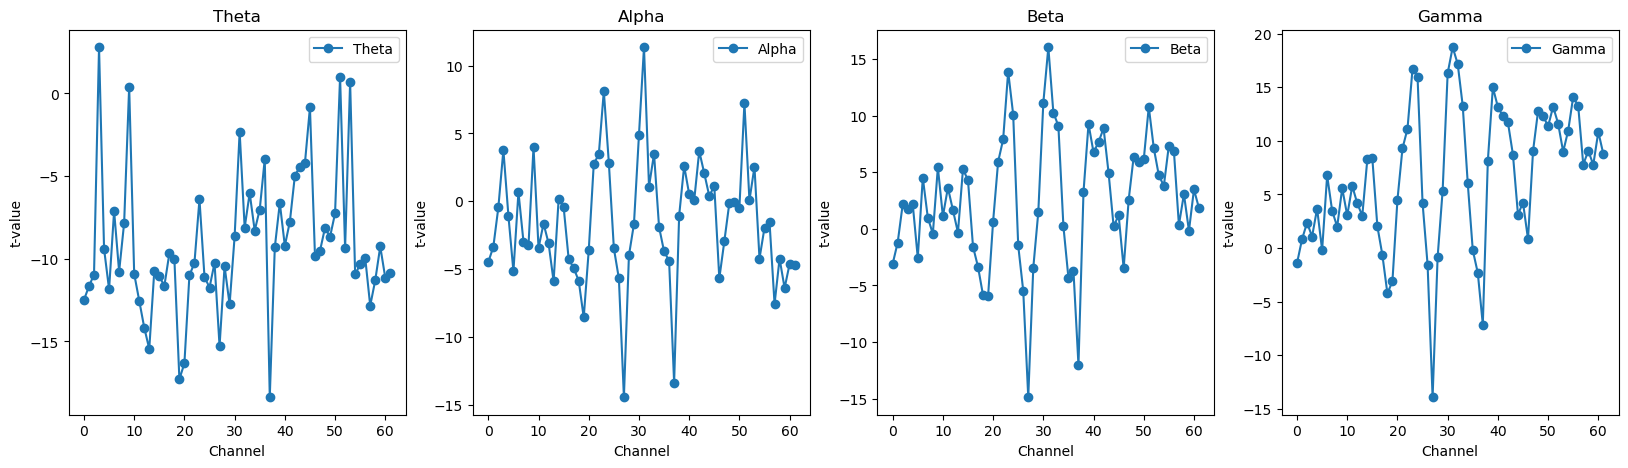

In [385]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, band in enumerate(freq_bands):
    axs[i].plot(p_values[:, i], marker='o', linestyle='-', label=f'{band}')
    axs[i].axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
    axs[i].set_title(f'{band}')
    axs[i].set_xlabel('Channel')
    axs[i].set_ylabel('p-value')
    axs[i].set_ylim([0, 1])
    axs[i].legend()
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, band in enumerate(freq_bands):
    axs[i].plot(t_values[:, i], marker='o', linestyle='-', label=f'{band}')
    axs[i].set_title(f'{band}')
    axs[i].set_xlabel('Channel')
    axs[i].set_ylabel('t-value')
    axs[i].legend()

plt.show()

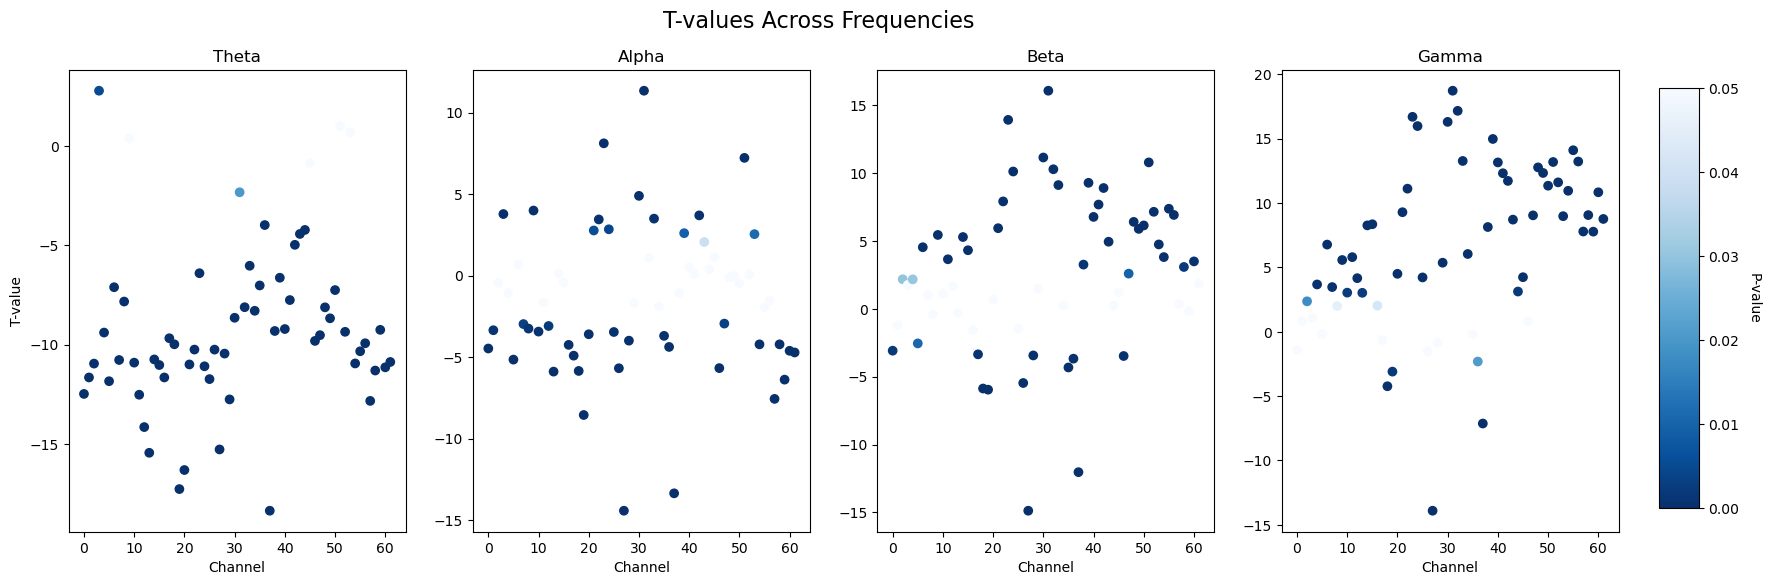

In [334]:
n_channels = len(CHLS)
n_freqs = 4

t_values = np.zeros((n_channels, n_freqs))
p_values = np.zeros((n_channels, n_freqs))

# Welch's t-test 수행
for ch in range(n_channels):
    for i, band in enumerate(freq_bands):
        ind_data = random_epochs_ind.get_data()[:, ch, i]
        ood_data = random_epochs_ood.get_data()[:, ch, i]
        
        t_value, p_value = ttest_ind(ind_data, ood_data, equal_var=False)
        t_values[ch, i] = t_value
        p_values[ch, i] = p_value


fig, axs = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle('T-values Across Frequencies', fontsize=16)

for i, band in enumerate(freq_bands):
    ax = axs[i]
    sc = ax.scatter(range(n_channels), t_values[:, i], c=p_values[:, i], cmap='Blues_r', vmin=0, vmax=0.05)
    ax.set_title(f"{band}")
    
    ax.set_xlabel('Channel')
    if i == 0:
        ax.set_ylabel('T-value')
    
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(sc, cax=cbar_ax)
cbar.set_label('P-value', rotation=270, labelpad=15)

plt.show()

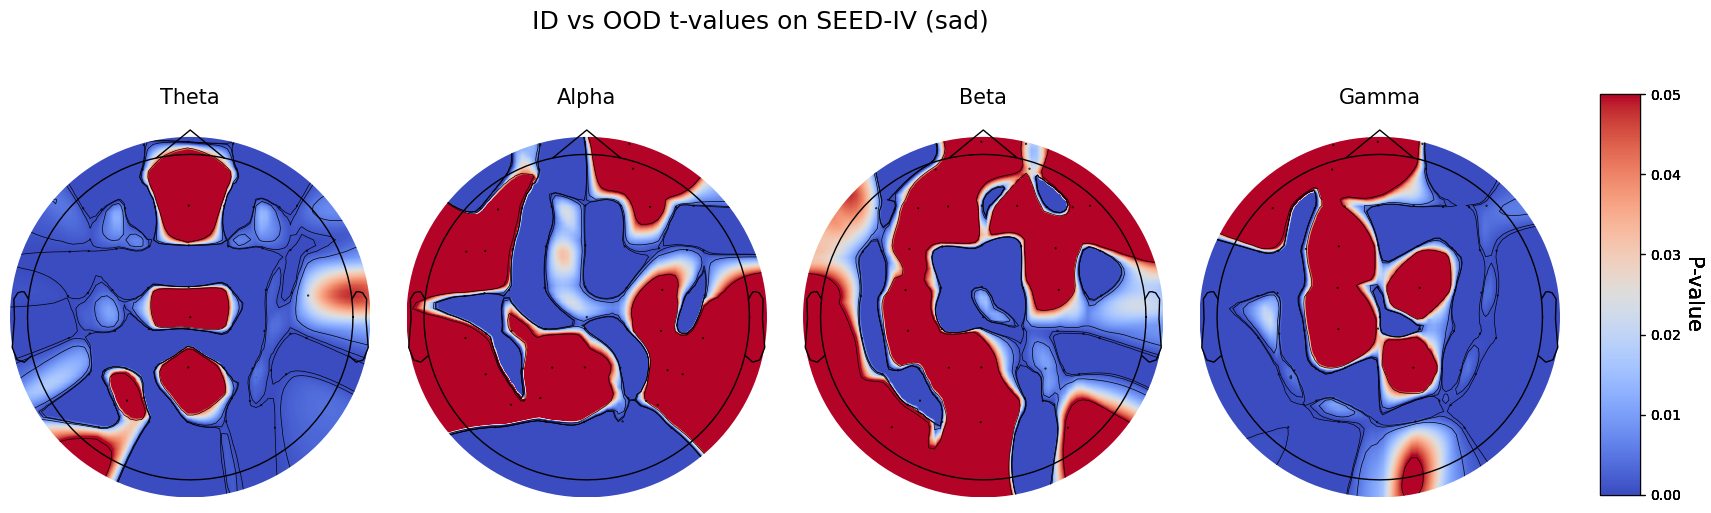

In [392]:
# fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# for i, band in enumerate(freq_bands):
#     im, _ = mne.viz.plot_topomap(t_values[:, i], info, cmap="coolwarm", axes=axs[i], show=False, vlim=(-8, 8))
#     axs[i].set_title(f"{band}", fontsize=15)

#     cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.8])
#     plt.colorbar(im, cax=cbar_ax, format="%1d")
#     plt.subplots_adjust(wspace=0.1, hspace=0.1)

# plt.suptitle(f"ID vs OOD t-value on SEED-IV ({label_name})", ha='center', fontsize=18, x=0.52, y=1.12 )
# # plt.savefig(join(analysis_path, f'{label_name}_ANOVA.png'), bbox_inches='tight', dpi=300)
# plt.show()

from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('custom_cmap', [(0, 0, 1), (1, 1, 1)], N=256)

colors = [(0, 0, 1), (0.2, 0.2, 0), (1,1,1)] 
n_bins = 100  # 빈 개수
cmap_name = 'custom_p_value_cmap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle(f'ID vs OOD t-values on SEED-IV ({label_name})', fontsize=18, y= 1.12)

for i, band in enumerate(freq_bands):
    im, _ = mne.viz.plot_topomap(p_values[:, i], info, axes=axs[i], cmap='coolwarm', vlim=(0, 0.05), contours=[0, 0.001, 0.005, 0.05], show=False)
    axs[i].set_title(f"{band}", fontsize=15)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.8])
    cbar = plt.colorbar(im, cax=cbar_ax)
    cbar.set_label('P-value', rotation=270, labelpad=15, fontsize=15)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.savefig(join(analysis_path, f'{label_name}_t.png'), bbox_inches='tight', dpi=300)
plt.show()

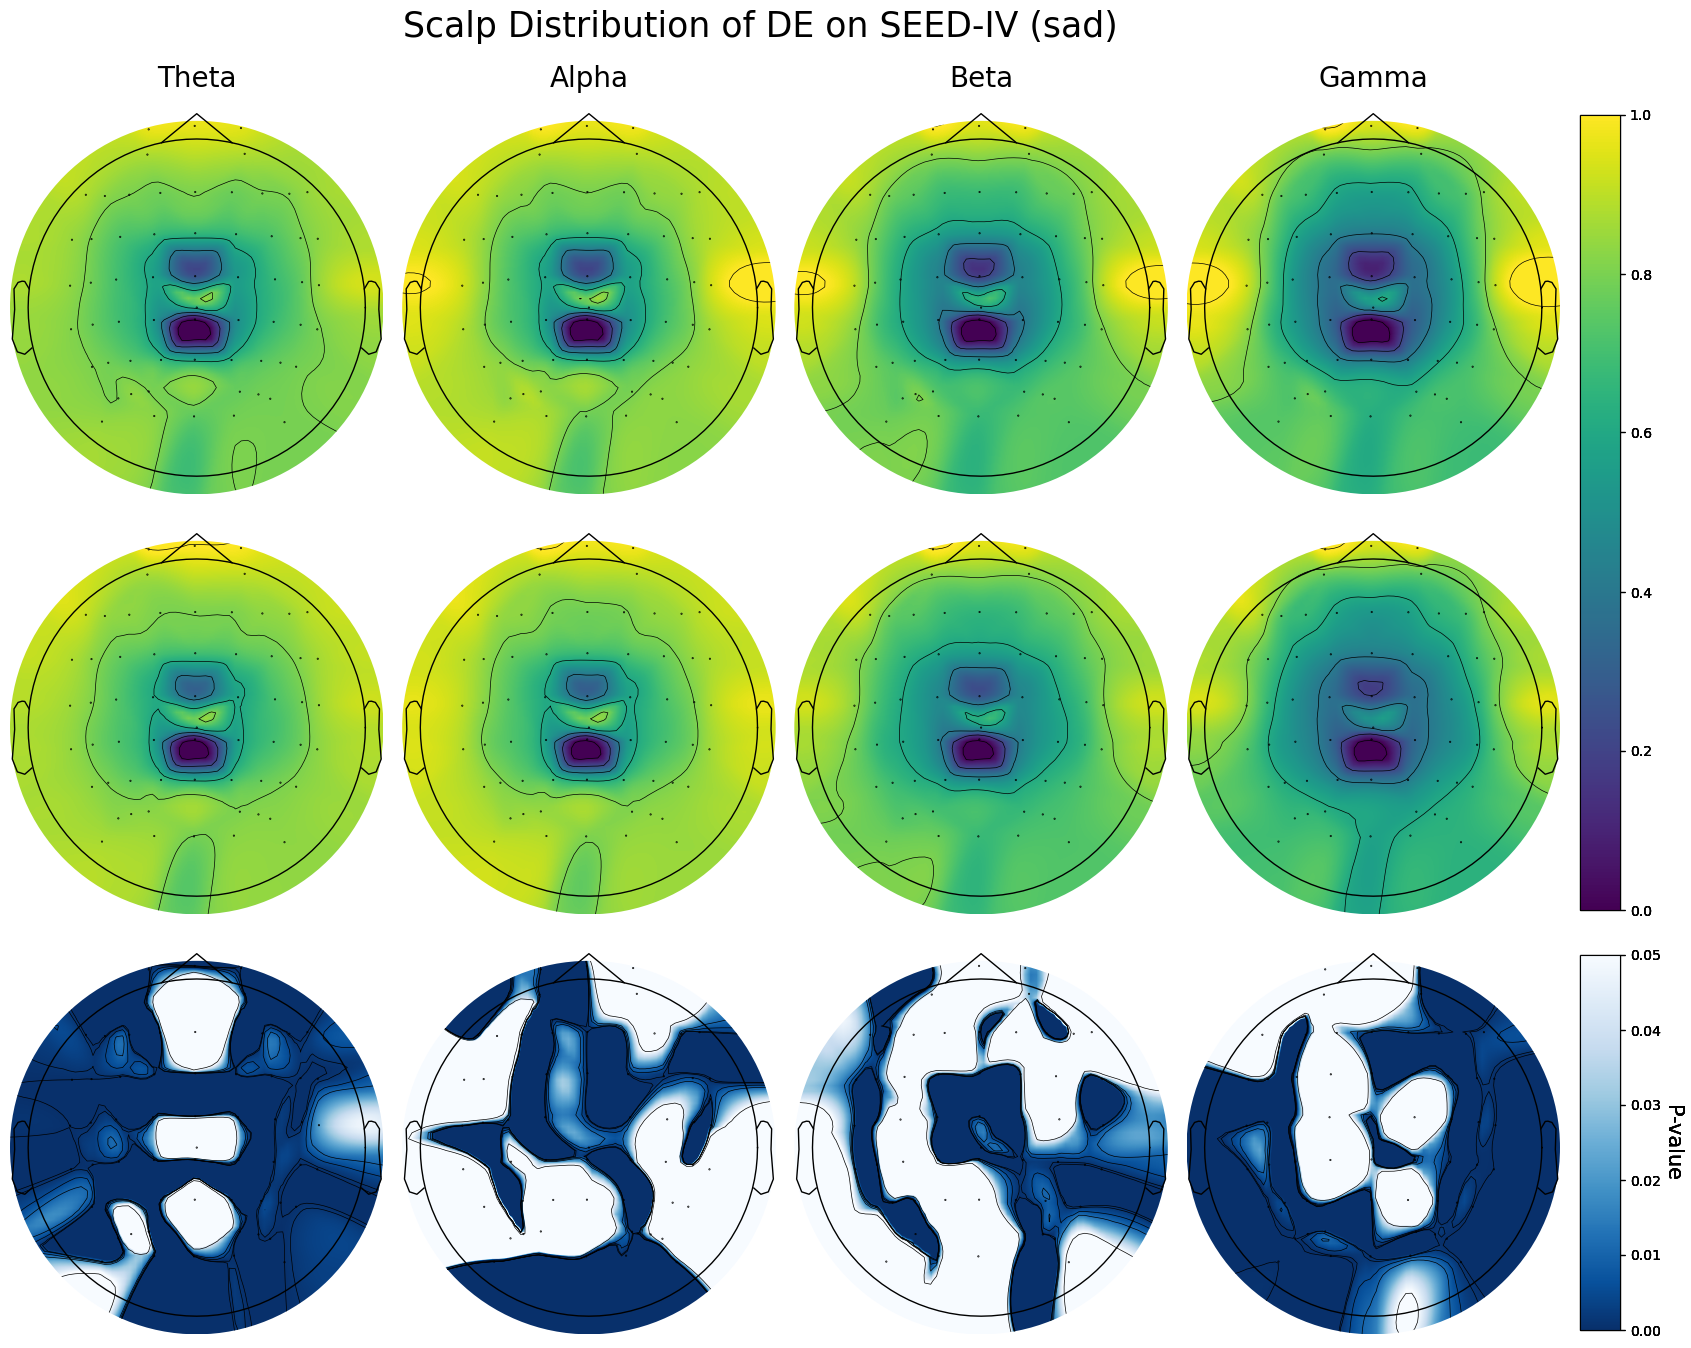

In [393]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle(f'Scalp Distribution of DE on SEED-IV ({label_name})', fontsize=25, y= 1)

for col, (band, de) in enumerate(band_ind.items()):
    im, _ = mne.viz.plot_topomap(de, info, axes=axs[0, col], cmap='viridis', show=False, vlim=(0,1)) 
    axs[0, col].set_title(f"{band}", fontsize=20)
    
for col, (band, de) in enumerate(band_ood.items()):
    im, _ = mne.viz.plot_topomap(de, info, axes=axs[1, col], cmap='viridis', show=False, vlim=(0,1)) 
    # axs[1, col].set_title(f"{band}")
    
    cbar_ax = fig.add_axes([0.91, 0.4, 0.02, 0.53])
    plt.colorbar(im, cax=cbar_ax, format="%.1f")

for i, band in enumerate(freq_bands):
    im, _ = mne.viz.plot_topomap(p_values[:, i], info, axes=axs[2, i], cmap='Blues_r', vlim=(0, 0.05), contours=[0, 0.001, 0.005, 0.01, 0.05], show=False)
    # axs[2, i].set_title(f"", fontsize=20)

    cbar_ax = fig.add_axes([0.91, 0.12, 0.02, 0.25])
    cbar = plt.colorbar(im, cax=cbar_ax)
    cbar.set_label('P-value', rotation=270, labelpad=15, fontsize=15)
    
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig(join(analysis_path, f'{label_name}_t.png'), bbox_inches='tight', dpi=300)
plt.show()

# PSD 
## TSC 에서만 됩니다..

In [ ]:
# def get_minmax(inds, oods):
#     combined = np.concatenate([inds, oods], axis=0)
#     return np.min(combined), np.max(combined)
    
# def get_indood(epochs_ind, epochs_ood):
#     freq_bands = {'Theta': [4, 8], 'Alpha': [8, 14], 'Beta': [14, 30], 'Gamma': [30, 49]}
    
#     ind_band = {band: [] for band in freq_bands.keys()}
#     ood_band = {band: [] for band in freq_bands.keys()}
    
#     for band, f_range in freq_bands.items():
#         print(band)
#         # Compute PSD
#         spectrum_ind = epochs_ind.compute_psd(fmin=f_range[0], fmax=f_range[1], verbose=False).get_data()
#         spectrum_ood = epochs_ood.compute_psd(fmin=f_range[0], fmax=f_range[1], verbose=False).get_data()

#         spectrum_ind = np.mean(spectrum_ind, axis=2)
#         spectrum_ood = np.mean(spectrum_ood, axis=2)
        
#         # Average per epoch with log transform
#         inds = np.mean(np.log1p(spectrum_ind), axis=0)
#         oods = np.mean(np.log1p(spectrum_ood), axis=0)
                                            
#         # Normalize
#         min_val, max_val = get_minmax(inds, oods)
#         inds = (inds - min_val) / (max_val - min_val)
#         oods = (oods - min_val) / (max_val - min_val)
               
#         ind_band[band] = inds
#         ood_band[band] = oods
        
#     return ind_band, ood_band

# band_ind, band_ood = get_indood(random_epochs_ind, random_epochs_ood)

In [ ]:
# def plot_psd_topomap(band_psd, label, fig, axs):
#     pos = [(0, 0), (0, 1), (1, 0), (1, 1)]
    
#     for p, (band, psd) in zip(pos, band_psd.items()):
#         im, _ = mne.viz.plot_topomap(psd, epochs_ind.info, axes=axs[p[0], p[1]], cmap='viridis', show=False, vlim=(0,1))
#         axs[p[0], p[1]].set_title(f"{band}")

#     cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.82])
#     plt.colorbar(im, cax=cbar_ax, format="%.1f")
#     plt.subplots_adjust(wspace=0.2, hspace=0.1)

# fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# plot_psd_topomap(band_ind, 'ID', fig, axs[:, :2])
# axs[0, 0].text(1.1, 1.2, 'ID', fontsize=16, ha='center', transform=axs[0, 0].transAxes)

# plot_psd_topomap(band_ood, 'OOD', fig, axs[:, 2:])
# axs[0, 2].text(1.1, 1.2, 'OOD', fontsize=16, ha='center', transform=axs[0, 2].transAxes)

# plt.suptitle(f'SEED-IV  {label_name}', ha='center', fontsize=18, x=0.52, y=1.1)
# plt.savefig(join(analysis_path, f'{label_name}_log_analysis.png'), bbox_inches='tight', dpi=300)
# plt.show()

In [110]:
mne.__version__

'1.4.2'